## Firedrake TC1

Check only the results for the last code bloc:
- Shock speed for analytical and theoretical comparison are in "TC1_shock_speed+comparison.png"
- After the pulse has passed the discharge becomes constant again. See the grey line for final time for $Q(s,t)$ of "TC1_final.png"

In [2]:
import random
def random_color():
    r = random.randint(0, 255) /255
    g = random.randint(0, 255)/255
    b = random.randint(0, 255)/255
    return (r,g,b)

Basic code with added color function, legend, and plot of A(s,t). Applying discharge $Q_{max}=350$

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Prior to start time loop. Hallo!
time counter and time:  1 0.3192754284070505


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


time counter and time:  3524 1125.1266097064868
time counter and time:  7048 2250.253219412898
time counter and time:  10571 3375.0605536902453
time counter and time:  14095 4500.187163396575
time counter and time:  17619 5625.313773103931
time counter and time:  21142 6750.121107382881
time counter and time:  24666 7875.2477170902375
time counter and time:  28189 9000.055051366886
time counter and time:  31713 10125.181661071038
time counter and time:  35237 11250.30827077519
time counter and time:  38760 12375.115605050934
time counter and time:  42284 13500.242214755086
time counter and time:  45807 14625.049549030831
time counter and time:  49331 15750.176158734983
time counter and time:  52855 16875.302768439135
time counter and time:  56378 18000.11010271488
time counter and time:  56378 18000.11010271488


/tmp/ipykernel_162482/3838701743.py:314: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


Elapsed time (min): 4.78403643767039


/tmp/ipykernel_162482/3838701743.py:321: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('sweDG0FVEt.png')


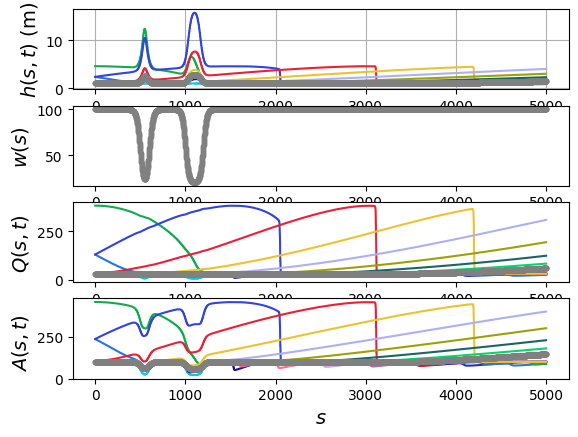

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


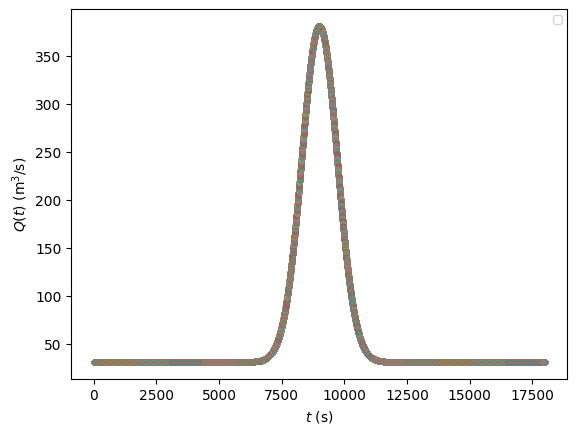

Program finished.


In [ ]:
#
#
# 1D St-Venant kinematic river flow
# O. Bokhove 02-10-2025
#
# See also: https://www.firedrakeproject.org/demos/DG_advection.py.html which one can (try to) adapt
#
# NOTE: Check TC0 and TC1
#
# TC2: to test and implement
#
#
# from firedrake import *
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"


#
# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # total simulation time
    CFL = 0.5*1.0 # CFL condition
    Lx = 5000 # Length of the domain
    grav = 9.81 # gravitational acceleration
    xo = 1000 
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100 # width parameters
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 0 # UPDATE 0: A=w0*h ;
    # 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    #                 R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0) 
    #                 A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0) 
    H0 = 1
    slope = -0.001 # -d_s b slope of the bed
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1 # Manning coefficient between 0.05 and 0.15
    Nx = 2500 # number of mesh cells
    dxx = Lx/Nx  # width of mesh cells
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0, TC2-pretest) 0 constant influx; TC1/TC2) nonzero varying influx; on top of base flux
    tmax = 0.5*Tend
    gamfac = 0.000001
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny) # not used
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data # not used
x, = fd.SpatialCoordinate(mesh)

#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous for width function wid0=w0(s)
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
h00 = fd.Function(DG0, name="h00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to 
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
Ab = fd.Constant(wb*hb) # OB14112025
wbb = fd.Constant(wb)
hbb = fd.Constant(hb)
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 if nRP==0:
  A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 elif nRP==1:
   A0 = fd.Function(DG0).interpolate(H0*wbb+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)
 
t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)

nx = 2*Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
tsize = 14
# ax1.set_title(r'$t=0,2,4,5,5.5,6,6.5,8.5,9.5$',fontsize=tsize) ax1.set_ylabel(r'$h(s,t)=h(A(s,t)),s)$ (m)',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()
ax2.set_ylabel(r'$w(s)$ ',fontsize=tsize)
ax4.set_xlabel(r'$s$ ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ ',fontsize=tsize)
ax4.set_ylabel(r'$A(s,t)$  ',fontsize=tsize)
# 
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
# ---- TEST CASE 0 and 1 -----
# ----------------------------
if nRP==0:
 phi12 = np.array([wid0.at(x) for x in xvals]) # Test function
# Mannin Flux formula
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) # TC0/TC1
 h00 = fd.Function(DG0).interpolate( A0/widL )
 # ---- TEST CASE 2 -----
 # ----------------------------
elif nRP==1:
 phi12 = np.array([wid0.at(x) for x in xvals]) # Test function
 h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
 # Mannin Flux formula
 FA00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm ) ) # TC2
Q12 = np.array([FA00.at(x) for x in xvals]) #
eta12 = np.array([h00.at(x) for x in xvals]) # 
ax1.plot(xvals,eta12,'--c')
ax2.plot(xvals,phi12)
ax3.plot(xvals,Q12,'--c')
ax4.plot(xvals,np.array([A0.at(x) for x in xvals]),'--c')
fig.savefig('TC1_initial.png') 
# 
# 
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0 widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-')) 
n = fd.FacetNormal(mesh) # outward normals
#
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0.0)
if nRP==0:
 #
 A0left = fd.Constant(H0*widL0) # constant inflow for test case
 A0left0 = H0*widL0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case UPDATE to conditional works only if H0<hb; now cannot work when Q0 large but fixed below in time loop
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<Ab, sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm # FA0left0 does not need fd.Constant  
 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm # FA0left0 does not need fd.Constant  
 FA0left.assign( FA0left0 )
 print('A0left0,FA0left0',A0left0,FA0left0)
 Peromi = fd.conditional( A0('-')<Ab, wbb+2*A0('-')/wbb, wbb+2*hbb+widL-wbb+2*(A0('-')-Ab)/widL )
 Peripl = fd.conditional( A0('+')<Ab, wbb+2*A0('+')/wbb, wbb+2*hbb+widL-wbb+2*(A0('+')-Ab)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<Ab, (5*wbb+6*A0avg/wbb)/(wbb+2.0*A0avg/wbb)**(5/3),\
                                                           (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0avg/widL)/(wbb+2*hbb+widL-wbb+2*(A0avg-Ab)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<Ab, (5*wbb+6*A0/wbb)/(wbb+2.0*A0/wbb)**(5/3) , \
                                                             (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0/widL)/(wbb+2*hbb+widL-wbb+2*(A0-Ab)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left,FA0left)# 
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
#t_.assign(t)
#solv1.solve()
dt = dt0

print('Prior to start time loop. Hallo!')
nt = 0
tic = time.time()
#
while t <= Tend: #while nt<10:
    t += dt
    nt = nt+1
    
    t_.assign(t)
    # Variable time step:
    # dFdmax = fd.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax
    #
    # Assign inflow: FA0left0 does not need fd.Constant  
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
    # print('FA0left0',FA0left0)
    FA0left.assign(Q00) # 
      
    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t>tmease+smallfac: # if nt>0:
        # print('t, tmeas:',t, tmease)
        col = random_color()
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        #  eta12 = np.array([A0.at(x) for x in xvals]) # 
        phi12 = np.array([wid0.at(x) for x in xvals])
        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
          h00 = fd.Function(DG0).interpolate( A0/widL )
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
          h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
        eta12 = np.array([h00.at(x) for x in xvals]) # 
        Q12 = np.array([FA00.at(x) for x in xvals])
        ax1.plot(xvals,eta12,'-', color = col, label ='t={:.1f}s'.format(t)) #
        ax2.plot(xvals,phi12,'-', color = col)
        ax3.plot(xvals,Q12,'-', color = col) #
        ax4.plot(xvals,np.array([A0.at(x) for x in xvals]),'-', color = col)
    #if t>tmE+smallfac:
    plt.figure(2)
    plt.plot(t,Q00,'.')
    
# Plot Last profile
print('time counter and time: ',nt, t)
phi12 = np.array([wid0.at(x) for x in xvals])
if nRP==0:
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
 h00 = fd.Function(DG0).interpolate( A0/widL )
elif nRP==1:
 FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
 h00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,A0/wbb,hbb+(A0-Ab)/widL) )
# 
eta12 = np.array([h00.at(x) for x in xvals]) # 
Q12 = np.array([FA00.at(x) for x in xvals]) # 
ax1.plot(xvals,eta12,'.',linewidth=3, color = 'grey') #
ax2.plot(xvals,phi12,'.',linewidth=3, color = 'grey') 
ax3.plot(xvals,Q12,'.',linewidth=3, color = 'grey')
ax4.plot(xvals,np.array([A0.at(x) for x in xvals]),'.', color = 'grey') #
plt.legend(fontsize=8)
toc = time.time() - tic
print('Elapsed time (min):', toc/60)
fig.savefig('TC1_final.png')
plt.figure(2)
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.savefig('TC1_inflow_flux.png')
plt.show()
print('Program finished.')


The code below calculate theoretical and numerical shock speed, see "TC1_shock_speed_comparison.png"

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Prior to start time loop. Hallo!


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


time counter and time:  56378 18000.11010271488


/tmp/ipykernel_601/2570716996.py:342: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


Elapsed time (min): 12.846014952659607


/tmp/ipykernel_601/2570716996.py:349: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('TC1_inflow_flux.png')


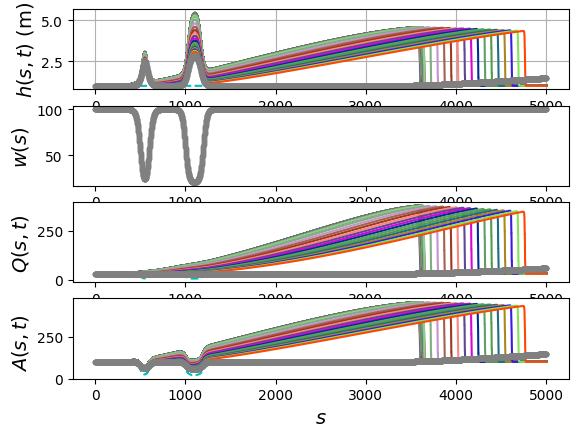

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


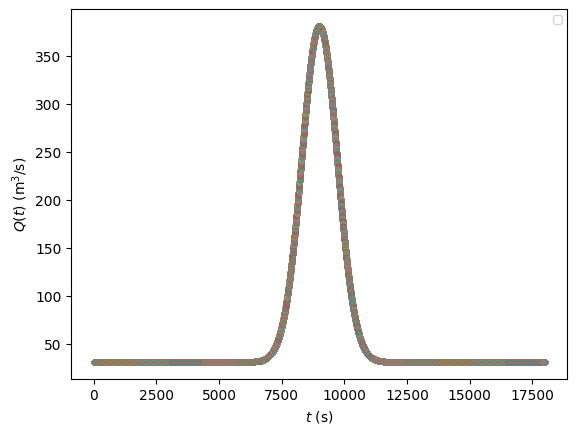

Program finished.


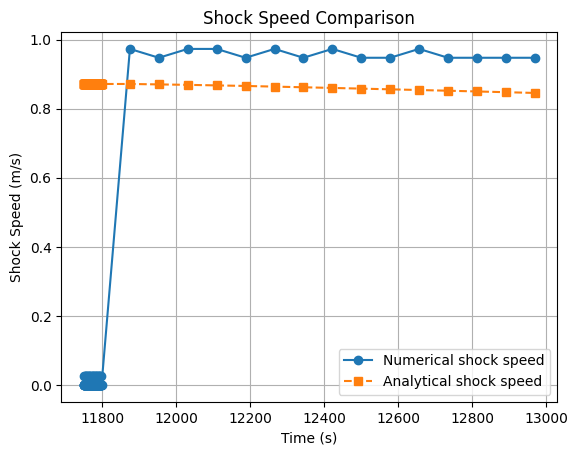

In [8]:
#LEGE
#
# 1D St-Venant kinematic river flow
# O. Bokhove 02-10-2025
#
# See also: https://www.firedrakeproject.org/demos/DG_advection.py.html which one can (try to) adapt
#
# NOTE: Check TC0 and TC1
#
# TC2: to test and implement
#
#
# from firedrake import *
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"


#
# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # total simulation time
    CFL = 0.5*1.0 # CFL condition
    Lx = 5000 # Length of the domain
    grav = 9.81 # gravitational acceleration
    xo = 1000 
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100 # width parameters
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 0 # UPDATE 0: A=w0*h ;
    # 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    #                 R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0) 
    #                 A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0) 
    H0 = 1
    slope = -0.001 # -d_s b slope of the bed
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1 # Manning coefficient between 0.05 and 0.15
    Nx = 2500 # number of mesh cells
    dxx = Lx/Nx  # width of mesh cells
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0, TC2-pretest) 0 constant influx; TC1/TC2) nonzero varying influx; on top of base flux
    tmax = 0.5*Tend
    gamfac = 0.000001
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny) # not used
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data # not used
x, = fd.SpatialCoordinate(mesh)

#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous for width function wid0=w0(s)
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
h00 = fd.Function(DG0, name="h00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to 
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
Ab = fd.Constant(wb*hb) # OB14112025
wbb = fd.Constant(wb)
hbb = fd.Constant(hb)
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 if nRP==0:
  A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 elif nRP==1:
   A0 = fd.Function(DG0).interpolate(H0*wbb+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)
 
t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)

nx = 2*Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
tsize = 14
# ax1.set_title(r'$t=0,2,4,5,5.5,6,6.5,8.5,9.5$',fontsize=tsize) ax1.set_ylabel(r'$h(s,t)=h(A(s,t)),s)$ (m)',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()
ax2.set_ylabel(r'$w(s)$ ',fontsize=tsize)
ax4.set_xlabel(r'$s$ ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ ',fontsize=tsize)
ax4.set_ylabel(r'$A(s,t)$  ',fontsize=tsize)
# 
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
# ---- TEST CASE 0 and 1 -----
# ----------------------------
if nRP==0:
 phi12 = np.array([wid0.at(x) for x in xvals]) # Test function
# Mannin Flux formula
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) # TC0/TC1
 h00 = fd.Function(DG0).interpolate( A0/widL )
 # ---- TEST CASE 2 -----
 # ----------------------------
elif nRP==1:
 phi12 = np.array([wid0.at(x) for x in xvals]) # Test function
 h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
 # Mannin Flux formula
 FA00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm ) ) # TC2
Q12 = np.array([FA00.at(x) for x in xvals]) #
eta12 = np.array([h00.at(x) for x in xvals]) # 
ax1.plot(xvals,eta12,'--c')
ax2.plot(xvals,phi12)
ax3.plot(xvals,Q12,'--c')
ax4.plot(xvals,np.array([A0.at(x) for x in xvals]),'--c')
fig.savefig('TC1_initial.png') 
# 
# 
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0 widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-')) 
n = fd.FacetNormal(mesh) # outward normals
#
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0.0)
if nRP==0:
 #
 A0left = fd.Constant(H0*widL0) # constant inflow for test case
 A0left0 = H0*widL0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case UPDATE to conditional works only if H0<hb; now cannot work when Q0 large but fixed below in time loop
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<Ab, sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm # FA0left0 does not need fd.Constant  
 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm # FA0left0 does not need fd.Constant  
 FA0left.assign( FA0left0 )
 print('A0left0,FA0left0',A0left0,FA0left0)
 Peromi = fd.conditional( A0('-')<Ab, wbb+2*A0('-')/wbb, wbb+2*hbb+widL-wbb+2*(A0('-')-Ab)/widL )
 Peripl = fd.conditional( A0('+')<Ab, wbb+2*A0('+')/wbb, wbb+2*hbb+widL-wbb+2*(A0('+')-Ab)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<Ab, (5*wbb+6*A0avg/wbb)/(wbb+2.0*A0avg/wbb)**(5/3),\
                                                           (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0avg/widL)/(wbb+2*hbb+widL-wbb+2*(A0avg-Ab)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<Ab, (5*wbb+6*A0/wbb)/(wbb+2.0*A0/wbb)**(5/3) , \
                                                             (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0/widL)/(wbb+2*hbb+widL-wbb+2*(A0-Ab)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left,FA0left)# 
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
#t_.assign(t)
#solv1.solve()
dt = dt0

print('Prior to start time loop. Hallo!')
nt = 0
tic = time.time()
#
nt_ploting = 0
arr_area = []
num_vel = []
anal_vel = []
time_array = []
while t <= Tend: #while nt<10:
    t += dt
    nt = nt+1

    # Calculate elapsed time in seconds since start of time loop
    elapsed_sec = time.time() - tic

    t_.assign(t)
    # Variable time step:
    # dFdmax = fd.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax
    #
    # Assign inflow: FA0left0 does not need fd.Constant  
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
    # print('FA0left0',FA0left0)
    FA0left.assign(Q00) # 
      
    solv1.solve()
    A0.assign(A1)
    #
    #
    # Looking for A only in this specific interval to capture the shock!
    if t>tmease+smallfac and t> 11750 and t < 13000: # if nt>0:
        dtmeas = 1250.0/nmea
        # print('t, tmeas:',t, tmease)
        col = random_color()
        tmease = tmease + dtmeas
        nnm = nnm+1
        #  eta12 = np.array([A0.at(x) for x in xvals]) # 
        phi12 = np.array([wid0.at(x) for x in xvals])
        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
          h00 = fd.Function(DG0).interpolate( A0/widL )
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
          h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
        eta12 = np.array([h00.at(x) for x in xvals]) # 
        Q12 = np.array([FA00.at(x) for x in xvals])
        A12 = np.array([A0.at(x) for x in xvals])

        arr_area.append(A12)
        if len(arr_area)>1:
          A_1_max = float(np.max(arr_area[-2]))
          A_2_max = float(np.max(arr_area[-1]))
          A_1_min = float(np.min(arr_area[-2]))
          A_2_min = float(np.min(arr_area[-1]))
          x_1_min = xvals[np.argmin(arr_area[-2])]
          x_1_max = xvals[np.argmax(arr_area[-2])]
          x_2_max = xvals[np.argmax(arr_area[-1])]
          num_vel.append((x_2_max - x_1_max)/(dtmeas))
          
          FAR = sqrtmslope*A_1_max**(5/3)/(wid0.at(x_1_max)+2.0*A_1_max/wid0.at(x_1_max))**(2/3)/Cm
          FAL = sqrtmslope*A_1_min**(5/3)/(wid0.at(x_1_min)+2.0*A_1_min/wid0.at(x_1_min))**(2/3)/Cm
          anal_vel.append((FAR - FAL)/(A_1_max - A_1_min))
          time_array.append(t)

        # Add elapsed tto the legend label
        ax1.plot(xvals,eta12,'-', color = col, label =f't={t:.0f}s')
        ax2.plot(xvals,phi12,'-', color = col)
        ax3.plot(xvals,Q12,'-', color = col) #
        ax4.plot(xvals,A12,'-', color = col)
        #if nt_ploting == 9 or nt_ploting == 10 or 
        nt_ploting = nt_ploting + 1
    #if t>tmE+smallfac:
    plt.figure(2)
    plt.plot(t,Q00,'.')
# ...existing code...
    
# Plot Last profile
print('time counter and time: ',nt, t)

if nRP==0:
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
 h00 = fd.Function(DG0).interpolate( A0/widL )
elif nRP==1:
 FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
 h00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,A0/wbb,hbb+(A0-Ab)/widL) )
# 
phi12 = np.array([wid0.at(x) for x in xvals])
eta12 = np.array([h00.at(x) for x in xvals]) # 
Q12 = np.array([FA00.at(x) for x in xvals]) # 
ax1.plot(xvals,eta12,'.',linewidth=3, color = 'grey') #
ax2.plot(xvals,phi12,'.',linewidth=3, color = 'grey') 
ax3.plot(xvals,Q12,'.',linewidth=3, color = 'grey')
ax4.plot(xvals,np.array([A0.at(x) for x in xvals]),'.', color = 'grey') #
plt.legend(fontsize=8)
toc = time.time() - tic
print('Elapsed time (min):', toc/60)
fig.savefig('TC1_final.png')
plt.figure(2)
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.savefig('TC1_inflow_flux.png')
plt.show()

# Plot shock speed results
plt.plot(time_array, num_vel, 'o-', label='Numerical shock speed')
plt.plot(time_array, anal_vel, 's--', label='Analytical shock speed')
plt.xlabel('Time (s)')
plt.ylabel('Shock Speed (m/s)')
plt.title('Shock Speed Comparison')
plt.legend()
plt.grid()
plt.savefig('TC1_shock_speed_comparison.png')
print('Program finished.')
